In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import numpy as np
import os, sys 
sys.path.append(os.getcwd())

In [3]:
# load state dataset: Louisiana
file1 = "../orig/LA_East_Baton_Rouge_Charges.csv"
dfLouisiana = pd.read_csv(os.path.join(os.path.dirname('__file__'),file1))
dfLouisiana.head(3)

,Unnamed: 0,Scrape_Date,State,County,Facility_Name,State_Code,Jail_ID,Name,Sex,Race,Booking_Date,Release_Date,Status,Bond_Amount,Bond_Date,Charge,Court,File_Number,Statute
0,0,2019-09-25,LA,East Baton Rouge,East Baton Rouge Prison,19,1237,THOMAS RAY AARON,M,Black,2019-09-11,2019-09-12,RELEASED,20000.0,None,POSS SCH 1 DRUGS,19TH JDC,19-00049606,40:966C
1,1,2019-09-25,LA,East Baton Rouge,East Baton Rouge Prison,19,1237,JARED ABADIE,M,Black,2019-09-23,None,9/23/2019,0.0,None,DIST/MANF SCH1 DRUG,19TH JDC,-,40:966A
2,2,2019-09-25,LA,East Baton Rouge,East Baton Rouge Prison,19,1237,ERIC JOSEPH ACHANE,M,Black,2019-09-05,2019-09-21,RELEASED,0.0,None,CRUELTY TO ANIMALS,19TH JDC,19-00051088,14:102.1


In [201]:
# # load BJS
# file1 = "../penal_codes/BJS Offense_Code_Crosswalk.xlsx"
# dfBJS = pd.read_excel(os.path.join(os.path.dirname('__file__'),file1))
# dfBJs.head(3)

ImportError: Can't determine version for xlrd

In [4]:
# remove columns -- Scrape_date, State, County, Facility Name, State Code, Jail ID (all same)
# remove column -- Bond_Date (nothing/a date/None) telling no significant distinguishment
# remove column -- Court (has 3 different cities labelled all differently by human error)
# remove column -- File_number (very sparse; not very useful)
tempLA = dfLouisiana.copy()
tempLA.drop(['Scrape_Date','State','County','Facility_Name','State_Code','Jail_ID'], axis=1, inplace=True)
tempLA.drop(['Bond_Date','Court', 'File_Number'], axis=1, inplace=True)
tempLA.sort_values(by=['Name','Booking_Date'], ascending=True, na_position='first')
tempLA.head(3)

,Unnamed: 0,Name,Sex,Race,Booking_Date,Release_Date,Status,Bond_Amount,Charge,Statute
0,0,THOMAS RAY AARON,M,Black,2019-09-11,2019-09-12,RELEASED,20000.0,POSS SCH 1 DRUGS,40:966C
1,1,JARED ABADIE,M,Black,2019-09-23,None,9/23/2019,0.0,DIST/MANF SCH1 DRUG,40:966A
2,2,ERIC JOSEPH ACHANE,M,Black,2019-09-05,2019-09-21,RELEASED,0.0,CRUELTY TO ANIMALS,14:102.1


In [5]:
# observe among how many of the released inmates, how long they stayed in the jail for, for each bail bond amounts
# clean duration of stay in jail (Release data - booking date)
# remove booking and release, and then append duration
from datetime import *

duration_jail = []
for book, release, status in zip(list(tempLA['Booking_Date']), list(tempLA['Release_Date']), list(tempLA['Status'])):
    book_tokens = book.split('-')
    if book_tokens[0] == 'None':
        bookdate = -1;  
        continue
    else:
        book_yy = int(book_tokens[0])
        book_mm = int(book_tokens[1])
        book_dd = int(book_tokens[2])
        bookdate = date(book_yy, book_mm, book_dd)
    
    release_tokens = release.split('-')
    if release_tokens[0] == 'None':        
        duration = -1
    else:
        release_yy = int(release_tokens[0])
        release_mm = int(release_tokens[1])
        release_dd = int(release_tokens[2])
        releasedate = date(release_yy, release_mm, release_dd)
        if bookdate is not -1:
            duration = releasedate - bookdate
        else:
            duration = -1
    # append value only if status is released, else -1
    if (status == 'RELEASED' and duration is not -1):
        duration_jail.append(int(duration.days))
    else:
        duration_jail.append(int(-1))

duration_jail = pd.Series(duration_jail)
tempLA2 = tempLA.copy()
tempLA2.drop(['Booking_Date','Release_Date'], axis=1, inplace=True)
tempLA2.insert(3, 'Duration_Jail', duration_jail)
tempLA2 = tempLA2.dropna()
tempLA2.head(-5)

# get indexes for which column 'Duration_Jail' has invalid values, and drop them
indexValidDuration = tempLA2[ tempLA2['Duration_Jail'] == -1 ].index
tempLA2.drop(indexValidDuration , inplace=True)
tempLA2.head(-5)
# tempLA2 contains only relevant/significant features, and cleaned status/durations --> more concise

,Unnamed: 0,Name,Sex,Duration_Jail,Race,Status,Bond_Amount,Charge,Statute
0,0,THOMAS RAY AARON,M,1.0,Black,RELEASED,20000.0,POSS SCH 1 DRUGS,40:966C
2,2,ERIC JOSEPH ACHANE,M,16.0,Black,RELEASED,0.0,CRUELTY TO ANIMALS,14:102.1
37,37,JOSEPH ALEXANDER,M,13.0,White,RELEASED,0.0,HOLD/RET OTHER AGENC,88888
51,51,ARRINGTON JEROME ALLEN,M,2.0,Black,RELEASED,0.0,WARRANT/BENCH WARRAN,C.CR.P. ART
56,56,DEXTER ALLEN,M,435.0,Black,RELEASED,0.0,CRIM DAM TO PROP/AGG,14:55
...,...,...,...,...,...,...,...,...,...
280124,280124,DARRLYN WINFREY,M,82.0,Black,3/6/2019,0.0,CRIMINAL CONSPIRACY,14:26
280125,280125,UNIQUA WINSTON,F,82.0,Black,9/17/2019,1000000.0,DIST/MANF SCH 2 DRUG,40:967A
280126,280126,BRADLEY NORMAN WINTERS,M,82.0,Black,12/28/2018,120000.0,SECOND DEGREE MURDER,14:30.1
280155,280155,ERIK VALJUNN WOODS,M,12.0,Black,1/17/2019,0.0,SIMPLE ROBBERY,14:65


In [376]:
# 0. sort races and sex into bins and see corresponding average bail bond amounts

tempLA3 = tempLA2.copy()
# bins = pd.cut(tempLA3['Race'], ['Asian','Black','Hispanic','None','White'])

print('race_sex_bond',race_sex_bond.mean())
race_sex_bond = tempLA3.groupby(['Race','Sex'])['Bond_Amount']
plt.clf()
tempLA3.groupby(['Race','Sex'])['Bond_Amount'].size().plot(kind='bar')
plt.title('race & sex distributions for entire LA dataset')
plt.show()

print('race_bond',race_bond.mean())
race_bond = tempLA3.groupby(['Race'])['Bond_Amount']
plt.clf()
tempLA3.groupby(['Race'])['Bond_Amount'].size().plot(kind='bar')
plt.title('race distributions for entire LA dataset')
plt.show()


NameError: name 'race_sex_bond' is not defined

In [6]:
# bond amount distribution by BINSIZE dollar bins
binsize = 5000 # dollars
max_bond_amount = 1000000 # 1 million

totalidx = 0
i = 0
j = binsize
# bond_duration_bin_total = pd.DataFrame(columns=['Duration_Jail', 'Bond_Amount', 'Count'])
bond_duration_bin_total = pd.DataFrame(columns=['Duration_Jail', 'Bond_Amount'])
while (j <= max_bond_amount):
    idx1 = tempLA2[tempLA2['Bond_Amount'] > i].index
    idx2 = tempLA2[tempLA2['Bond_Amount'] <= j].index
    idx = idx1 & idx2
    duration_jail_in_bin = tempLA2.loc[idx]

    # by race only
    # sort by bond amount range
    bins = pd.cut(duration_jail_in_bin['Bond_Amount'], [i, j])
    df_bins = duration_jail_in_bin.groupby([bins,'Race']
)['Duration_Jail','Bond_Amount']
# uncommnt below for race / race&sex distribution plots
#     print('means by race:',df_bins.mean())
#     print('counts by race:',df_bins.count())
#     plt.clf()
#     df_bins.size().plot(kind='bar')
#     plt.title('How many of each race falls into (0,5000] bond dollars')
#     plt.show()

#     # by race and sex
#     df_bins = duration_jail_in_bin.groupby([bins,'Race','Sex']
# )['Duration_Jail','Bond_Amount']
#     print('means by race and sex:',df_bins.mean())
#     print('counts by race and sex:',df_bins.count())
#     plt.clf()
#     df_bins.size().plot(kind='bar')
#     plt.title('How many of each race & sex falls into (0,5000] bond dollars')
#     plt.show()
#     break
#     race_bins = duration_jail_in_bin.groupby([bins,'Race','Sex'])['Bond_Amount','Duration_Jail']
#     df_counts = race_bins.count()['Bond_Amount'].rename(columns={"Bond_Amount":"count"})
    
    bond_duration_bin = df_bins.mean() # add columns 'duration' and 'bond amount' averages
    list_race = [len(duration_jail_in_bin[duration_jail_in_bin['Race']=='Asian']),\
    len(duration_jail_in_bin[duration_jail_in_bin['Race']=='Black']), \
    len(duration_jail_in_bin[duration_jail_in_bin['Race']=='Hispanic']),\
    len(duration_jail_in_bin[duration_jail_in_bin['Race']=='None']),\
    len(duration_jail_in_bin[duration_jail_in_bin['Race']=='White'])]
        
    # bond_duration_bin.insert(2, 'Count', len(idx)) # add total counts in the bin
    if len(idx) > 0:
        bond_duration_bin_total = bond_duration_bin_total.append(bond_duration_bin, sort=False)

    # if j < 10001:
    #     print(bond_duration_bin)
    #     print("-------------------------------------------")

    i += binsize
    j += binsize
    totalidx += 1
# - save
bond_duration_bin_total.to_csv('./bond_duration_bin_total.csv', index=True)
bond_duration_bin_total.head()

,Duration_Jail,Bond_Amount
"((0, 5000], Asian)",0.000000,5000.000000
"((0, 5000], Black)",56.406295,1868.520260
"((0, 5000], Hispanic)",74.000000,3559.000000
"((0, 5000], None)",70.769231,3441.025641
"((0, 5000], White)",71.855721,2326.834577


<Figure size 432x288 with 0 Axes>

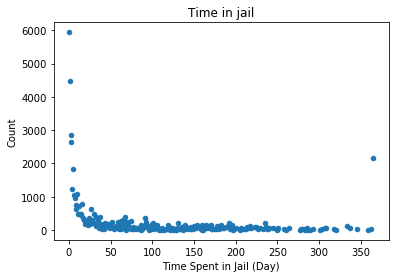

<Figure size 432x288 with 0 Axes>

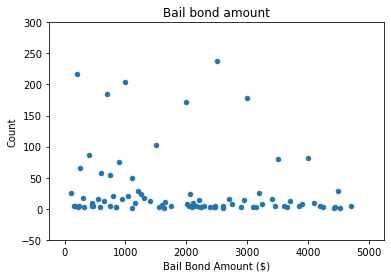

In [166]:

# 1. times spent for each state on average, average bond amounts for each state
data = tempLA2.copy()
durations = pd.DataFrame(data.groupby(['Duration_Jail'])['Unnamed: 0'].count()).sort_values(['Duration_Jail'], ascending=True, axis=0)
bondamts = pd.DataFrame(data.groupby(['Bond_Amount'])['Unnamed: 0'].count()).sort_values(['Bond_Amount'], ascending=True, axis=0)

# clean up durations in jail up to 1 year
yeardays = 365
countoveroneyear = 0
for index in list(durations.index):
    colvalue = durations.loc[index,:].values
    if index > yeardays:
        countoveroneyear += float(colvalue)   
        durations.drop(index)

durations = durations[durations.index < yeardays]

add_dict = dict({'Unnamed: 0':np.float(countoveroneyear)})
add_dict = pd.DataFrame(data=add_dict, index=[str(yeardays)])
durations = pd.concat([durations, add_dict], axis=0)
durations.rename(columns={"Unnamed: 0": "Count"}, errors="raise", inplace=True)

# clean up bail amounts
limit = 5000
countoverfivethousand = 0
for index in list(bondamts.index):
    colvalue = bondamts.loc[index,:].values
    if index > limit:
        countoverfivethousand += float(colvalue)   
        bondamts.drop(index)
# print(countoverfivethousand)

bondamts = bondamts[bondamts.index < limit]
add_dict = dict({'Unnamed: 0':np.float(countoverfivethousand)})
add_dict = pd.DataFrame(data=add_dict, index=[str(limit)])
bondamts = pd.concat([bondamts, add_dict], axis=0)
bondamts.rename(columns={"Unnamed: 0": "Count"}, errors="raise", inplace=True)

durations.index = durations.index.astype(int)
bondamts.index = bondamts.index.astype(int)
# save files
durations.to_csv("./durations.csv", header=True, index=True, index_label=['Days in Jail'])
bondamts.to_csv("./bontamts.csv", header=True, index=True, index_label=['Bond $'])
# scatter plot

import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = durations.reset_index().plot(kind='scatter', x='index', y='Count', marker='o',  title='Time in jail')
ax1.set_xlabel("Time Spent in Jail (Day)")
plt.savefig('./durations.png')

fig = plt.figure()
ax2 = bondamts.reset_index().plot(kind='scatter', x='index', y='Count', marker='o', title='Bail bond amount',ylim=(-50,300))
ax2.set_xlabel("Bail Bond Amount ($)")
plt.savefig('./bondsamts')


In [185]:
# 2.  for certain range, counts and demographic info
allraces = np.unique(list(tempLA2['Race']))
lenraces = []
for i in range(len(allraces)):
    lenraces.append(len(tempLA2[tempLA2['Race']==allraces[i]]))
races = dict(zip(allraces, lenraces))

allsexes = np.unique(list(tempLA2['Sex']))
lensexes = []
for i in range(len(allsexes)):
    lensexes.append(len(tempLA2[tempLA2['Sex']==allsexes[i]]))
sexes = dict(zip(allsexes, lensexes))

allcharges = np.unique(list(tempLA2['Charge']))
lencharges = []
for i in range(len(allcharges)):
    lencharges.append(len(tempLA2[tempLA2['Charge']==allcharges[i]]))
charges = dict(zip(allcharges, lencharges))


print(races)
print(sexes)
print(len(charges))
print(charges)

{'Asian': 41, 'Black': 38761, 'Hispanic': 946, 'None': 352, 'White': 8551}
{'F': 6545, 'M': 42106}
297
{'ACCESS DEVICE FRAUD': 101, 'ACCESSORIES AFTER TH': 31, 'ADD LIGHTING EQUIP': 8, 'AGGRAVATED ARSON': 29, 'AGGRAVATED ASSAULT': 127, 'AGGRAVATED BATTERY': 364, 'AGGRAVATED BATTERY/G': 4, 'AGGRAVATED BURGLARY': 145, 'AGGRAVATED KIDNAPPIN': 69, 'ANNUAL REG FEE REQUI': 9, 'APPLICABILITY OF OTH': 2, 'ARMED ROBBERY': 1220, 'ASSAULT BY DRIVE-BY': 94, 'ASSAULT/AGG DOMESTIC': 102, 'ASSAULT/AGG/CC': 51, 'ASSAULT/SIMPLE/CC': 132, 'ATTEMPT': 73, 'BACKING UNSAFELY': 5, 'BANK FRAUD': 120, 'BATT/AGG ORAL SEX': 15, 'BATT/DATING PARTNER': 205, 'BATT/POLICE OFF/CC': 19, 'BATT/SIMPLE': 12, 'BATT/SIMPLE/CC': 314, 'BATTERY OF A POLICE': 128, 'BURG/AUTO $50 - $200': 7, 'BURG/AUTO OVER $200': 34, 'BURG/AUTO UNDER $50': 3, 'BURG/S NON RES NIGHT': 8, 'BURGLARY/S INHAB DWE': 543, 'BURGLARY/SIMPLE': 1908, 'CARELESS DRIVING': 85, 'CARJACKING': 18, 'CHILD DESERTION': 18, 'CHILD RESTRAINT REQ': 195, 'CHILD RESTRA

In [375]:
# 3.  crime -- drug schedules
# bond, count, race info
filtered = tempLA2[tempLA2.Charge.str.contains("POSS SCH", case=False, na=False)]
charges = list(filtered.Charge)
idx = 0
idx_bond_nonzero = 0
print(filtered.columns[1:])

from collections import defaultdict 
# initialize dictionary to keep track over drug possession by schedules 1-5
sex_race_status_count = defaultdict(float)
bond_1_sum = bond_2_sum = bond_3_sum = bond_4_sum = bond_5_sum = 0

# print(filtered.iloc[43,:])
# raise Exception('nothing')
for charge in charges:
    temp = re.findall(r'\d+', charge) 
    schedule = str(list(map(int, temp)))[1:-1]
    if not schedule.isdigit():
        if len(schedule) != 0:
            print("sch: {:s}, index: {:d}".format(schedule, idx))
        if 'I' in charge:
            schedule = '1'
        else:
            raise Exception("schedule empty")
    sex = filtered.iloc[idx,2]
    time = filtered.iloc[idx,3]
    race = filtered.iloc[idx,4]
    status = filtered.iloc[idx,5]
    bond = filtered.iloc[idx,6]
    
    sch_sex_key = (schedule, sex)
    sch_race_key = (schedule, race)
    sch_status_key = (schedule, status)
    sch_bond_key = (schedule, 'avgbond')
    
    if sch_sex_key in sex_race_status_count:
        sex_race_status_count[sch_sex_key] += 1
    else:
        sex_race_status_count[sch_sex_key] = 1
    
    if sch_race_key in sex_race_status_count:
        sex_race_status_count[sch_race_key] += 1
    else:
        sex_race_status_count[sch_race_key] = 1
    
    if not status[0].isdigit():
        if sch_status_key in sex_race_status_count:
            sex_race_status_count[sch_status_key] += 1
        else:
            sex_race_status_count[sch_status_key] = 1
    
#     print("bond (sch: %s): %i /" % (schedule,bond))
    if sch_bond_key in sex_race_status_count:
        sex_race_status_count[sch_bond_key] += bond
    else:
        sex_race_status_count[sch_bond_key] = bond
    if schedule == '1':
        bond_1_sum += bond
    elif schedule == '2':
        bond_2_sum += bond
    elif schedule == '3':
        bond_3_sum += bond
    elif schedule == '4':
        bond_4_sum += bond
    elif schedule == '5':
        bond_5_sum += bond
    idx += 1
    idx_bond_nonzero += 1
sex_race_status_count[('1','avgbond')] /= idx_bond_nonzero
sex_race_status_count[('2','avgbond')] /= idx_bond_nonzero
sex_race_status_count[('3','avgbond')] /= idx_bond_nonzero
sex_race_status_count[('4','avgbond')] /= idx_bond_nonzero
sex_race_status_count[('5','avgbond')] /= idx_bond_nonzero

df_sex_race_status_count = sorted(sex_race_status_count.items())
df_sex_race_status_count = pd.DataFrame(df_sex_race_status_count)
df_sex_race_status_count.rename(columns={0:'info', 1:'count'})
df_sex_race_status_count.to_csv('./df_sex_race_status_count.csv', index=False, header=['info','count'])
df_sex_race_status_count.head()

Index(['Name', 'Sex', 'Duration_Jail', 'Race', 'Status', 'Bond_Amount',
       'Charge', 'Statute'],
      dtype='object')


,0,1
0,"(1, Asian)",3.0
1,"(1, Black)",1136.0
2,"(1, F)",129.0
3,"(1, Hispanic)",1.0
4,"(1, M)",1315.0


In [6]:
# plot duration in jail vs bond amount
import plotly.express as px

fig = px.scatter(bond_duration_bin_total, x="Duration_Jail", y="Bond_Amount", trendline="ols")
fig.update_traces(
    line=dict(dash="dot", width=4),
    selector=dict(type="scatter", mode="lines"))
fig.update_layout(
    title={
    'text': "Scatterplot of bail bond vs. time in jail",
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title_text='Time spent in jail (day)', # xaxis label
    yaxis_title_text='Bond Amount ($)', # yaxis label
)
fig.show()
fig.write_image("scatterplot_bond_durationjail.png")

fig = go.Figure(data=[go.Histogram(x=bond_duration_bin_total.Count, histnorm='probability')])
fig.update_layout(
    title={
        'text': "Histogram of frequency of bail bonds",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title_text='Bail Bonds (bin, $)', # xaxis label
    yaxis_title_text='Normalized Frequency (count)', # yaxis label
)
fig.show()
fig.write_image("histogram_freq_bonds.png")


In [7]:
# load state dataset: Michigan
file3 = "./orig/MI_Wayne_Charges.csv"
dfMichigan = pd.read_csv(os.path.join(os.path.dirname('__file__'),file3))
dfMichigan.head(3)

In [8]:
# load state dataset: Arkansas
file4 = "./orig/AR_Washington_Charges.csv"
dfArkansas = pd.read_csv(os.path.join(os.path.dirname('__file__'),file4))
dfArkansas.head(3)

In [9]:
# load BJS (national)
# BJS
file2 = "./penal_codes/BJS Offense_Code_Crosswalk.xlsx"
dfBJS = pd.read_excel(os.path.join(os.path.dirname('__file__'),file2))

In [ ]:
dfBJS.head(5)

In [ ]:
# dfLouisiana.head(5)

In [188]:

filtBondAmountZero = dfLouisiana.copy()
filtBondAmountZero = filtBondAmountZero[filtBondAmountZero.Bond_Amount != 0]

# Determine male/female ratio per ethnicity in LA dataset
races = list(np.unique(filtBondAmountZero['Race']))
sexes = list(np.unique(filtBondAmountZero['Sex']))
population_race = filtBondAmountZero.groupby(by=['Race']).Race.count()
total_count = filtBondAmountZero.groupby(by="Race").Race.count().sum()
percentRace = population_race/total_count*100
race_percentage = dict(zip(races,  ["{0:0.2f}".format(p_race) for p_race in percentRace]))



mean_bond_per_sex_race = filtBondAmountZero.groupby(by=['Race','Sex']).mean()['Bond_Amount']
mean_bond_per_sex_race = dict(mean_bond_per_sex_race)
mean_bond_per_sex_race
# filter out NaN
import math
for i in mean_bond_per_sex_race.items():
    if math.isnan(i[1]):
        mean_bond_per_sex_race[i[0]] = 0


sex_per_race = filtBondAmountZero.groupby(by=['Race', 'Sex']).Sex.count()
# manual sum since each race has different number of sexes ('None' has three sexes)
total_sex_sum_by_race = [sum(sex_per_race[0:2]), sum(sex_per_race[0:2]), \
                        sum(sex_per_race[2:4]),  sum(sex_per_race[2:4]), \
                        sum(sex_per_race[4:6]),  sum(sex_per_race[4:6]), \
                        sum(sex_per_race[6:9]),  sum(sex_per_race[6:9]), sum(sex_per_race[6:9]), \
                        sum(sex_per_race[9:11]), sum(sex_per_race[9:11])]
samples = ["{0:0.2f}".format(val/total_sex_sum_by_race[i]*100) for i, val in enumerate(sex_per_race)]
sex_per_race_percentage = dict(zip(sex_per_race.keys(), samples))

print("\nrace percentage in LA")
print(race_percentage)

print("\nmean bond per race in LA")
print(mean_bond_per_sex_race)

print("\nsex percentage per race in LA")
print(sex_per_race_percentage)


race percentage in LA
{'Asian': '0.12', 'Black': '77.84', 'Hispanic': '2.47', 'None': '0.84', 'White': '18.72'}

mean bond per race in LA
{('Asian', 'F'): 30000.0, ('Asian', 'M'): 37068.181818181816, ('Black', 'F'): 31497.55859676176, ('Black', 'M'): 73299.45880183387, ('Hispanic', 'F'): 10108.695652173914, ('Hispanic', 'M'): 88959.41441441441, ('None', 'F'): 200.0, ('None', 'M'): 57026.64756446992, ('None', 'None'): 0, ('White', 'F'): 34711.952969310485, ('White', 'M'): 33976.1312655774}

sex percentage per race in LA
{('Asian', 'F'): '45.00', ('Asian', 'M'): '55.00', ('Black', 'F'): '11.33', ('Black', 'M'): '88.67', ('Hispanic', 'F'): '1.43', ('Hispanic', 'M'): '98.57', ('None', 'F'): '4.01', ('None', 'M'): '82.33', ('None', 'None'): '13.66', ('White', 'F'): '24.50', ('White', 'M'): '75.50'}


  Using cached https://files.pythonhosted.org/packages/12/55/30e2716d415bd938ffcc0f1835a770dfe2a8ce2401c5331a7c9074f66cb2/wordcloud-1.6.0-cp36-cp36m-win_amd64.whl


ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_inter

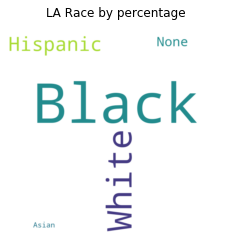

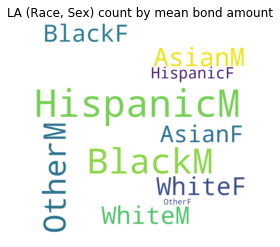

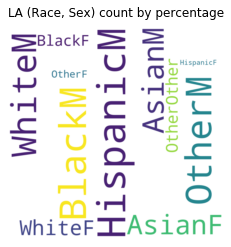

In [190]:
!pip install wordcloud
# race percentage ==================
for key in race_percentage:
    race_percentage[key] = int(float(race_percentage[key])*100)

# Create and generate a word cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(race_percentage)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("LA Race by percentage")
plt.savefig("./race_percentage.png")
plt.show()

# mean bond ==================
filtered = dict()
for key in mean_bond_per_sex_race:
    k = str(key).strip("(), ").replace("'",'').replace(", ",'').replace("None","Other")
    filtered[k] = int(float(mean_bond_per_sex_race[key])*100)

# Create and generate a word cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(filtered)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("LA (Race, Sex) count by mean bond amount")
plt.savefig("./mean_bond_per_sex_race.png")
plt.show()

# sex and race ==================
filtered = dict()
for key in sex_per_race_percentage:
    k = str(key).strip("(), ").replace("'",'').replace(", ",'').replace("None","Other")
    filtered[k] = int(float(sex_per_race_percentage[key])*100)

# Create and generate a word cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(filtered)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("LA (Race, Sex) count by percentage")
plt.savefig("./sex_per_race_percentage.png")
plt.show()

[54000.0, 66000.0, 8819272.0, 69020728.0, 35321.0, 2434679.0, 33684.0, 691572.0, 114744.0, 4586400.0, 14133600.0]


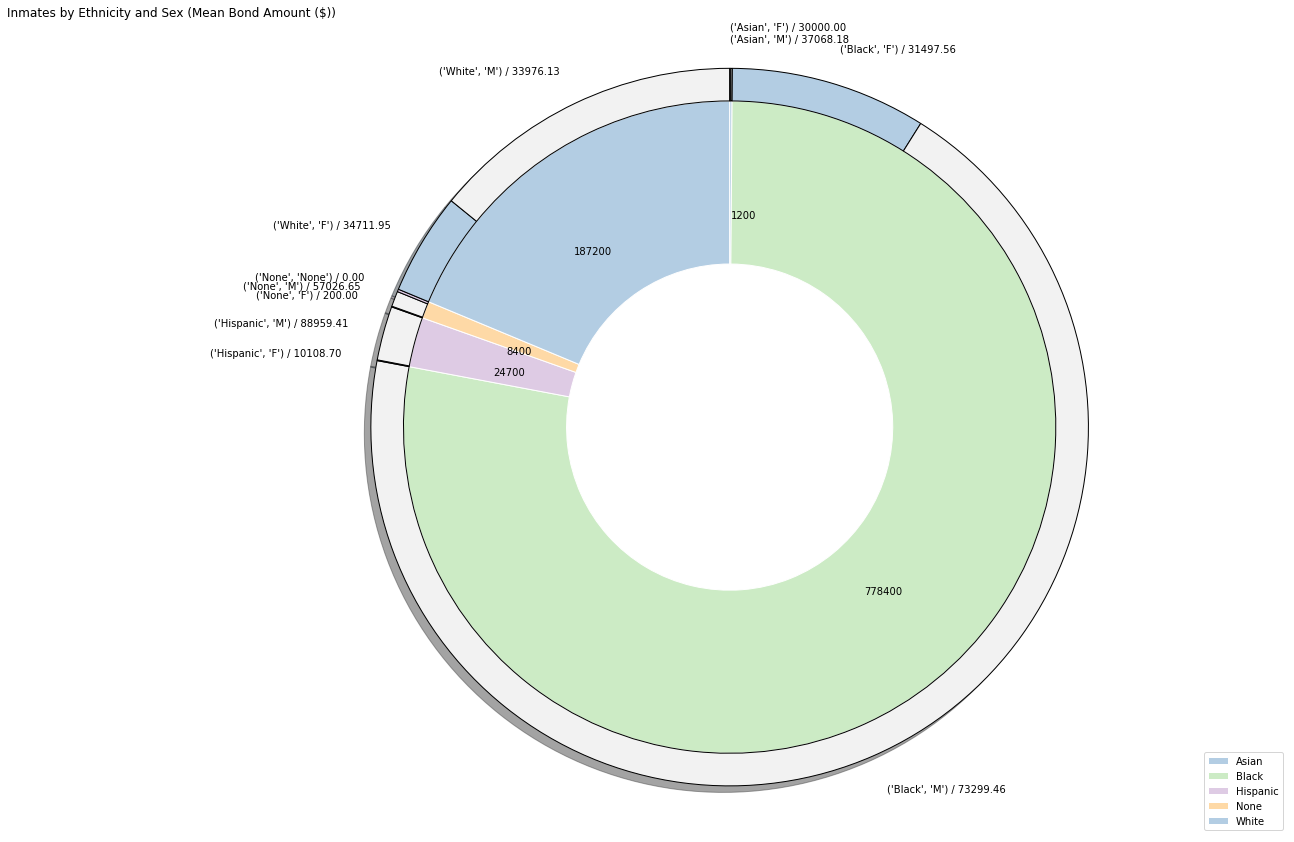

In [196]:
# donut plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
# import seaborn as sns
# sns.set()
%matplotlib inline

fig, ax = plt.subplots(figsize=(20,15))
ax.axis('equal')            # axis scale
cm1 = plt.get_cmap("Pastel1")  # color map
cm = plt.get_cmap("jet")  # color map

# outer pie (Sex by Race)
width1 = 0.5

data1 = list(race_percentage.values())
labels1 = list(race_percentage.keys())
cout = cm1(np.arange(1, len(data1), 1))

pie, _ = ax.pie(data1, radius=1, colors=cout, counterclock=False, startangle=90, labels=data1, labeldistance=0.65)
plt.setp(pie, width=width1, edgecolor='white')

# inner pie (Race)
width2 = 0.1
tempVal =  [list(race_percentage.values())[0], list(race_percentage.values())[0], \
                list(race_percentage.values())[1], list(race_percentage.values())[1], \
                list(race_percentage.values())[2], list(race_percentage.values())[2], \
                list(race_percentage.values())[3], list(race_percentage.values())[3], list(race_percentage.values())[3], \
                list(race_percentage.values())[4], list(race_percentage.values())[4]]

sex_race = [float(x) * float(y) for x,y in zip(list(sex_per_race_percentage.values()), tempVal)] 
data2 = sex_race
labels2 = [str(x)+" / "+str("{0:.2f}".format(float(bond))) for x, bond in zip(list(sex_per_race_percentage.keys()), list(mean_bond_per_sex_race.values()))]
labels2[0] = labels2[0] + '\n' + labels2[1]
labels2[1] = ''
print(data2)

units = list(['%', '']*4)
cm = plt.get_cmap("tab20c")  # color map
cin = cm1([1, 10, 1, 10, 1, 10, 1, 10, 3, 1, 10]) # 1: F, 10: M, 3: None

mpl.rcParams['font.size'] = 10.0
pie2, _ = ax.pie(data2, radius=1.1, labels=labels2, labeldistance=1.1, colors=cin, counterclock=False, startangle=90, shadow=True, rotatelabels=False)
plt.setp(pie2, width=width2, edgecolor='black')
plt.legend(list(labels1), loc='lower right')
plt.title('Inmates by Ethnicity and Sex (Mean Bond Amount ($))', loc='left', horizontalalignment='center', verticalalignment='center')
# plt.show()

plt.savefig('./Incarcerated by Ethnicity and Sex (Average Bonds).png')

In [198]:
# bond amount
bonds = pd.Series(list(dfLouisiana.Bond_Amount))
count_bonds = pd.value_counts(bonds).sort_index()
count_bonds.to_csv("./bond_amt_counts.csv")

C:\Users\jong7\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [199]:
# from BJS National Penal Codes (first sheet)

# BJS contains:
# ['arson','assault', 'blank', 'burglary','driving', 'drug possession', 'drug trafficking','federal offense', 'fraud', 'kidnapping', 'larceny', 'vehicle theft', 'murder', 'negligent manslaughter', 'non-negligent manslaughter', 'other', 'drug offenses', 'other property', 'other public order', 'other violent', 'robbery', 'sexual assault', 'stolen property', 'unspecified homicide', 'weapons offense']

# filter BJS categories by keywords
regkey = str(list(np.unique(r"\b(?i)"+dfBJS.bjs_category+"\b")))
filtered = dfBJS[dfBJS.bjs_category.str.contains(regkey, case=False, na=False)]
filteredBJS = dfBJS.iloc[filtered.index,:]
groupBJS = filteredBJS.groupby(['bjs_category'])
grps = dict(groupBJS.groups)

i = 1
for key in grps:
    print("{}. {} (count: {})".format(i, key, len(grps[key])))
    
    items = filteredBJS[filteredBJS.bjs_category==key].bjs_description.to_string(index=False).replace(' ','').split('\n')
    # print(items)
    for item in items:
        print("\t-", item, end='\n')
    i += 1


NameError: name 'dfBJS' is not defined

In [ ]:
# filter Louisiana charges by keywords
# filter out absolutely unnecessary columns
cols = list(range(8,len(dfLouisiana.columns)-3))
del cols[2:4]
dfLousiana_filter = dfLouisiana.iloc[:,cols]

key_countsLA = dict()
print("key : count")
for key in grps: # grps: from BJS
    key_splits = key.split()
    regkey = r"(?i)./*"+key_splits[0]+".*"
    i = 1
    while (i < len(key_splits)):
        regkey += '(?i).*'+key_splits[i]+'.*'
        i += 1
    # print(regkey)
    filtered = dfLousiana_filter[dfLousiana_filter.Charge.str.contains(regkey, case=False, na=False)]
    filteredLA = dfLousiana_filter.iloc[filtered.index]["Charge"]
    print("{} : {}".format(key,len(list(filteredLA.index))))
    if (len(list(filteredLA.index)) > 0):
        key_countsLA[key] = len(list(filteredLA.index))
    else:
        key_countsLA[key] = 0

In [ ]:
# filter Michigan charges by keywords
# remove 2,6,14,16,,20,21,22,23,24,25,26,27,28
cols = np.arange(0,len(dfMichigan.columns),1)
cols = [x for x in cols if x not in [2,6,14,16,20,21,22,23,24,25,26,27,28]]
dfMichigan_filter = dfMichigan.iloc[:,cols]
# dfMichigan_filter.Charge

key_countsMI = dict()
print("key : count")
for key in grps: # grps: from BJS
    key_splits = key.split()
    regkey = r"(?i)./*"+key_splits[0]+".*"
    i = 1
    while (i < len(key_splits)):
        regkey += '(?i).*'+key_splits[i]+'.*'
        i += 1
    # print(regkey)
    filtered = dfMichigan_filter[dfMichigan_filter.Charge.str.contains(regkey, case=False, na=False)]
    filteredMI = dfMichigan_filter.iloc[filtered.index]["Charge"]
    print("{} : {}".format(key,len(list(filteredMI.index))))
    if (len(list(filteredMI.index)) > 0):
        key_countsMI[key] = len(list(filteredLA.index))
    else:
        key_countsMI[key] = 0

In [ ]:
# filter Arkansas charges by keywords
dfArkansas_copy = dfArkansas

key_countsAR = dict()
print("key : count")
for key in grps: # grps: from BJS
    key_splits = key.split()
    regkey = r"(?i)./*"+key_splits[0]+".*"
    i = 1
    while (i < len(key_splits)):
        regkey += '(?i).*'+key_splits[i]+'.*'
        i += 1
    # print(regkey)
    filtered = dfArkansas_copy[dfArkansas_copy.Charge.str.contains(regkey, case=False, na=False)]
    filteredAR = dfArkansas_copy.iloc[filtered.index]["Charge"]
    print("{} : {}".format(key,len(list(filteredAR.index))))
    if (len(list(filteredAR.index)) > 0):
        key_countsAR[key] = len(list(filteredAR.index))
    else:
        key_countsAR[key] = 0

In [ ]:
# bar chart for filtered keywords
from textwrap import wrap
# !pip install textwrap

key_counts
fig, ax = plt.subplots(figsize=(100,64))
mpl.rcParams['font.size'] = 30.0
plt.subplot(311)
key_counts = key_countsLA
labels = [ '\n'.join(wrap(l, 10)) for l in list(key_counts.keys()) ]
p1 = plt.bar(labels, [int(x)/sum(key_counts.values()) for x in key_counts.values()], width=0.2)
plt.legend([p1[0]], ['LA (East Baton Rouge)'])
plt.title('Louisiana Charge Frequency by BJS Code Categoriess (National)', loc='center')

plt.subplot(312)
key_counts = key_countsMI
labels = [ '\n'.join(wrap(l, 10)) for l in list(key_counts.keys()) ]
p2 = plt.bar(labels, [int(x)/sum(key_counts.values()) for x in key_counts.values()], width=0.2)
plt.legend([p2[0]], ['MI (Wayne)'])
plt.title('Michigan Charge Frequency by BJS Code Categories (National)', loc='center')

plt.subplot(313)
key_counts = key_countsAR
labels = [ '\n'.join(wrap(l, 10)) for l in list(key_counts.keys()) ]
p3 = plt.bar(labels, [int(x)/sum(key_counts.values()) for x in key_counts.values()], width=0.2)
plt.title('Arkansas Charge Frequency by BJS Code Categories (National)', loc='center')

plt.legend([p3[0]], ['AR (Washington)'])
# plt.show()
plt.savefig('./bar_charts.png')

In [ ]:
# stacked bar graph
fig, ax = plt.subplots(figsize=(100,16))
mpl.rcParams['font.size'] = 30.0
key_counts = key_countsLA
labels = [ '\n'.join(wrap(l, 10)) for l in list(key_counts.keys()) ]
LA = [int(x)/sum(key_countsLA.values()) for x in key_countsLA.values()]
MI = [int(x)/sum(key_countsMI.values()) for x in key_countsMI.values()]
AR = [int(x)/sum(key_countsAR.values()) for x in key_countsAR.values()]
p1 = plt.bar(labels, LA, width=0.3)
p2 = plt.bar(labels, MI, width=0.3, bottom=LA)
p3 = plt.bar(labels, AR, width=0.3, bottom=MI)
plt.legend((p1[0], p2[0], p3[0]), ('LA (East Baton Rouge)', 'MI (Wayne)', 'AR (Washington)'))
plt.title('State Charge Frequency Comparison by BJS category')
# plt.show()
plt.savefig('./stacked_bar.png')

In [ ]:
# load BJS Penal codes for Louisiana
dfBJS_LA = pd.read_excel(os.path.join(os.path.dirname('__file__'),file2), sheet_name='LA')